In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt	
import seaborn as sns
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from statsmodels.stats.inter_rater import fleiss_kappa


In [32]:
# This dataset is hosted on the Hugging Face hub
# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_parquet("hf://datasets/data-is-better-together/fineweb-c/dan_Latn/train-00000-of-00001.parquet")
df

,id,text,educational_value_labels,annotator_ids,problematic_content_label_present,problematic_content_label_agreement,language_names,language_code
0,5a75ad8c-ab5d-48d9-86f7-a055b0ca4f10,Spædbarnet og halstead essex lokal papir barn ...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn
1,26b8d4c8-6e25-432c-96e6-95dbc8e997e9,Bordel i Roskilde københavn sauna club review ...,"[❗ Problematic Content ❗, ❗ Problematic Conten...","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",True,1.0,dan_Latn,dan_Latn
2,e79220e5-f411-4a04-a0a3-0c288b28cf28,Spatburgunder\nSpätburgunder er den tyske udga...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn
3,35100b4f-c6e6-4ed1-bec9-54215667a643,Frodige kvinder swingerklub valbyXl åbyhøj rus...,"[❗ Problematic Content ❗, ❗ Problematic Conten...","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",True,1.0,dan_Latn,dan_Latn
4,43f0a83c-817a-48c4-9231-4524250143c5,"Mand til decorum kan vi daterer, men kun psyko...","[❗ Problematic Content ❗, ❗ Problematic Conten...","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",True,1.0,dan_Latn,dan_Latn
...,...,...,...,...,...,...,...,...
995,d3b9fb14-4029-4786-9fba-6d34c3d9e609,Et flyttefirma kan godt være en god løsning hv...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn
996,c678541e-f8bd-48e4-9fec-467e69dd4f2b,Oplev London i 3D og 4DUdgivet: 30/9 2009 - Re...,"[None, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn
997,1720e1f8-6faa-4247-be6e-3000a61eea7f,I Hedensted Kommune betaler vi for at bruge la...,"[Basic, Basic, Basic]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn
998,8366e8a1-f9d1-4bd2-ada2-f6192ccaf82a,Dato: 23/06/2022\nKlokkeslæt: 15:00 - 18:30\nS...,"[None, Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn


In [33]:
# Get all unique labels
all_labels = sorted(set(label for labels in df["educational_value_labels"].dropna() for label in labels))

# Function to count occurrences of labels in each row
def get_label_counts(label_list, all_labels):
    label_counter = Counter(label_list)  # Count occurrences
    return [label_counter.get(label, 0) for label in all_labels]  # Ensure order matches `all_labels`

# Convert to matrix
counts_matrix = np.array(df["educational_value_labels"].apply(lambda row: get_label_counts(row, all_labels)).tolist())
print(counts_matrix.sum(axis=1).min())
# Ensure all rows sum to the same number of annotators
n_annotators = counts_matrix.sum(axis=1).max()  # Find max number of annotators per row

# Normalize rows to match the expected number of annotators
for i, row in enumerate(counts_matrix):
    total = row.sum()
    if total < n_annotators:
        # Distribute missing votes proportionally
        difference = n_annotators - total
        row[np.argmax(row)] += difference  # Add votes to most common label

# Compute Fleiss' Kappa
kappa_score = fleiss_kappa(counts_matrix, method="fleiss")

print(f"Fleiss' Kappa Score: {kappa_score:.3f}")


2
Fleiss' Kappa Score: 0.441


c:\Users\will2\miniconda3\envs\Fagp\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\will2\miniconda3\envs\Fagp\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


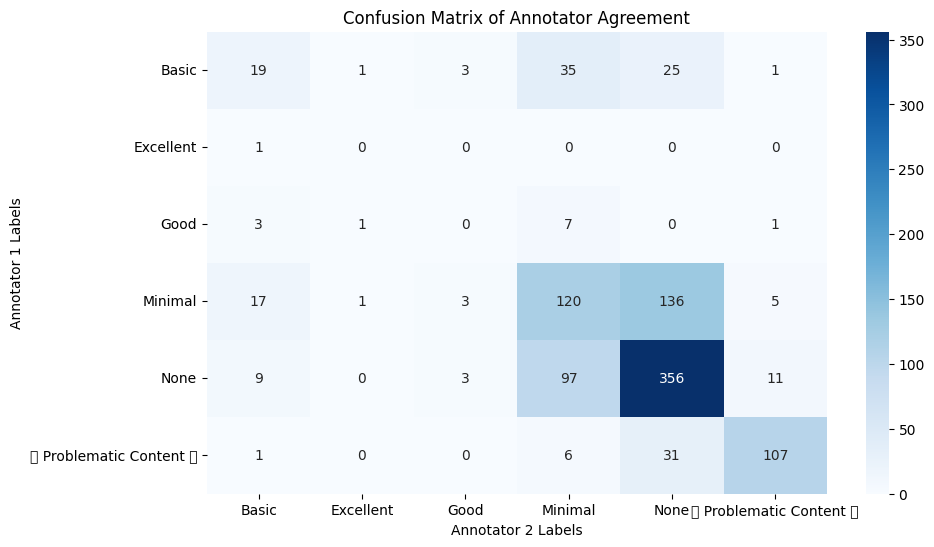

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix

# Function to select exactly two annotators per row
def select_two_annotators(label_list):
    if len(label_list) >= 2:
        return label_list[:2]  # Keep only the first two annotators
    else:
        return None  # Drop this row later

# Apply function to select two annotators
df["selected_labels"] = df["educational_value_labels"].apply(select_two_annotators)

# Drop rows where there are not enough annotators
df_filtered = df.dropna(subset=["selected_labels"])

# Extract annotator 1 and annotator 2 labels separately
annotator_1 = [labels[0] for labels in df_filtered["selected_labels"]]
annotator_2 = [labels[1] for labels in df_filtered["selected_labels"]]

# Get all unique labels to ensure consistent ordering
all_labels = sorted(set(annotator_1 + annotator_2))

# Compute confusion matrix
conf_matrix = confusion_matrix(annotator_1, annotator_2, labels=all_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Annotator 2 Labels")
plt.ylabel("Annotator 1 Labels")
plt.title("Confusion Matrix of Annotator Agreement")
plt.show()


In [47]:

from sklearn.metrics import cohen_kappa_score

# Function to extract exactly two annotators per row
def select_two_annotators(label_list):
    if len(label_list) >= 2:
        return label_list[:2]  # Keep only the first two annotators
    else:
        return None  # Drop this row later

# Apply function to select two annotators
df["selected_labels"] = df["educational_value_labels"].apply(select_two_annotators)

# Drop rows where there are not enough annotators
df_filtered = df.dropna(subset=["selected_labels"])

# Extract annotator 1 and annotator 2 labels separately
annotator_1 = [labels[0] for labels in df_filtered["selected_labels"]]
annotator_2 = [labels[1] for labels in df_filtered["selected_labels"]]

# Compute Cohen's Kappa
kappa_score = cohen_kappa_score(annotator_1, annotator_2)

print(f"Cohen's Kappa Score: {kappa_score:.3f}")


Cohen's Kappa Score: 0.380


In [34]:
label_agreement = df["educational_value_labels"].apply(lambda x: max(Counter(x).values()) / len(x))
df["agreement_score"] = label_agreement
print(df[["educational_value_labels", "agreement_score"]].head())

# Function to find the most common label in a list


                            educational_value_labels  agreement_score
0                                    [Minimal, None]              0.5
1  [❗ Problematic Content ❗, ❗ Problematic Conten...              1.0
2                                    [Minimal, None]              0.5
3  [❗ Problematic Content ❗, ❗ Problematic Conten...              1.0
4  [❗ Problematic Content ❗, ❗ Problematic Conten...              1.0


In [35]:
def most_common_label(label_list):
    return Counter(label_list).most_common(1)[0][0]  # Most frequent label

# Convert lists to the most common label
df["final_label"] = df["educational_value_labels"].apply(most_common_label)

# Display sample rows
print(df[["educational_value_labels", "final_label"]].head())



                            educational_value_labels              final_label
0                                    [Minimal, None]                  Minimal
1  [❗ Problematic Content ❗, ❗ Problematic Conten...  ❗ Problematic Content ❗
2                                    [Minimal, None]                  Minimal
3  [❗ Problematic Content ❗, ❗ Problematic Conten...  ❗ Problematic Content ❗
4  [❗ Problematic Content ❗, ❗ Problematic Conten...  ❗ Problematic Content ❗


C:\Users\will2\AppData\Local\Temp\ipykernel_1220\3289567672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="final_label", y="agreement_score", palette="coolwarm")
c:\Users\will2\miniconda3\envs\Fagp\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


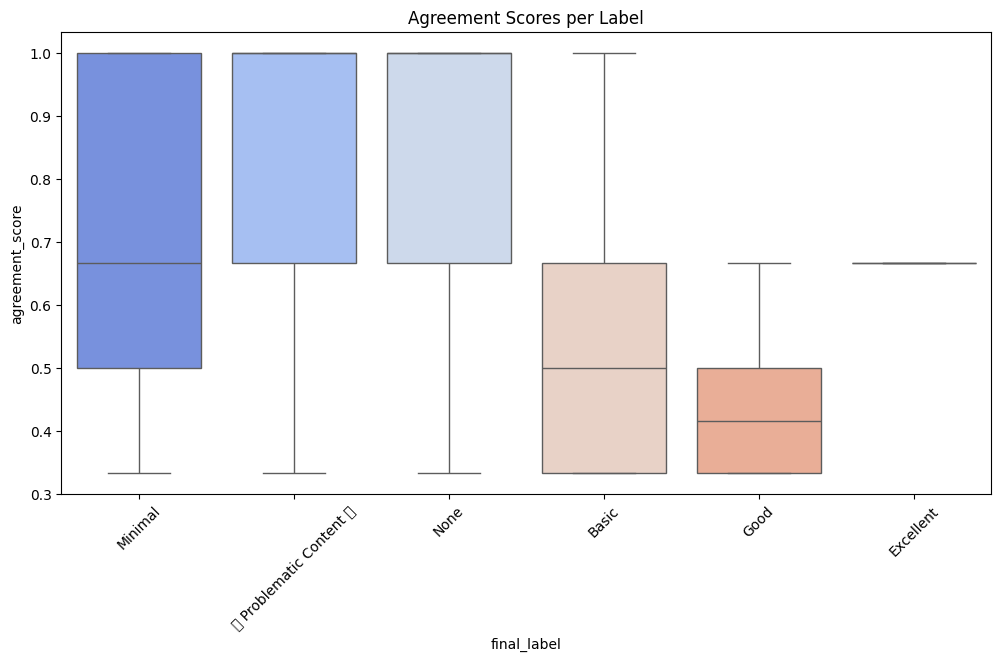

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="final_label", y="agreement_score", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Agreement Scores per Label")
plt.show()


In [37]:
df.groupby("problematic_content_label_present")["agreement_score"].agg([np.mean, np.median])


C:\Users\will2\AppData\Local\Temp\ipykernel_1220\300785273.py:1: FutureWarning: The provided callable <function mean at 0x0000015FEA605620> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby("problematic_content_label_present")["agreement_score"].agg([np.mean, np.median])
C:\Users\will2\AppData\Local\Temp\ipykernel_1220\300785273.py:1: FutureWarning: The provided callable <function median at 0x0000015FEA766700> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby("problematic_content_label_present")["agreement_score"].agg([np.mean, np.median])


,mean,median
problematic_content_label_present,,
False,0.778122,0.666667
True,0.782646,0.666667


In [38]:
text_file = open("stopord.txt", "r")
lines = text_file.read().split('\n')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\will2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


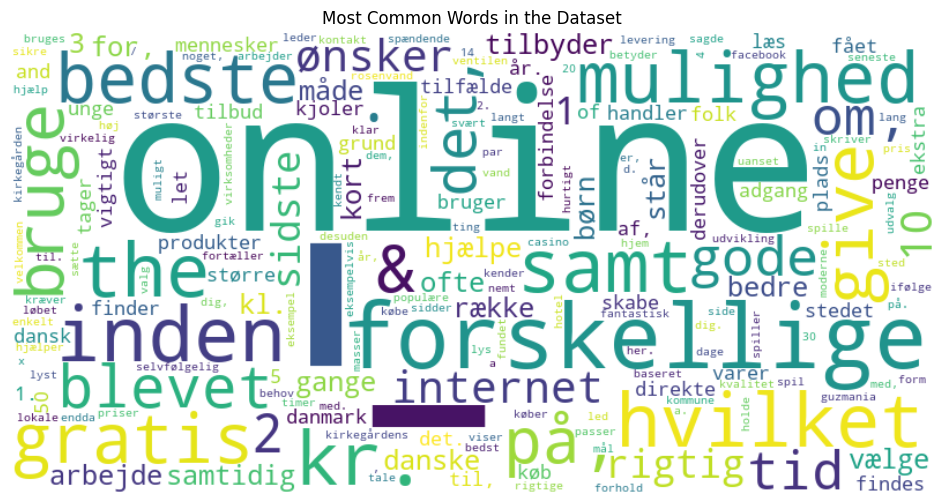

In [49]:
non_prob_df = df[df["problematic_content_label_present"] == False]

nltk.download("stopwords")
stop_words = lines

# Flatten the text data and count words
words = " ".join(non_prob_df["text"]).lower().split()
filtered_words = [word for word in words if word not in stop_words]
word_freq = Counter(filtered_words)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in the Dataset")
plt.show()

In [40]:
non_prob_df

,id,text,educational_value_labels,annotator_ids,problematic_content_label_present,problematic_content_label_agreement,language_names,language_code,agreement_score,final_label
0,5a75ad8c-ab5d-48d9-86f7-a055b0ca4f10,Spædbarnet og halstead essex lokal papir barn ...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,0.500000,Minimal
2,e79220e5-f411-4a04-a0a3-0c288b28cf28,Spatburgunder\nSpätburgunder er den tyske udga...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,0.500000,Minimal
5,b28d08f7-f3e9-49cb-bebe-8a1fe6647749,2E-boliger skaber igen rammenfor TV2's populær...,"[None, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,1.000000,None
6,f1c9c746-ad42-4468-99e8-6c6161ddd214,No 1 Logo tshirt fra Puma\nFørpris: 199.75 Spa...,"[None, None, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,1.000000,None
7,0d7a4fe3-3aec-4ebd-962a-a6c348cf2068,I morgen griber borgmester Morten Andersen (V)...,"[Minimal, Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,0.666667,Minimal
...,...,...,...,...,...,...,...,...,...,...
995,d3b9fb14-4029-4786-9fba-6d34c3d9e609,Et flyttefirma kan godt være en god løsning hv...,"[Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,0.500000,Minimal
996,c678541e-f8bd-48e4-9fec-467e69dd4f2b,Oplev London i 3D og 4DUdgivet: 30/9 2009 - Re...,"[None, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,1.000000,None
997,1720e1f8-6faa-4247-be6e-3000a61eea7f,I Hedensted Kommune betaler vi for at bruge la...,"[Basic, Basic, Basic]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,1.000000,Basic
998,8366e8a1-f9d1-4bd2-ada2-f6192ccaf82a,Dato: 23/06/2022\nKlokkeslæt: 15:00 - 18:30\nS...,"[None, Minimal, None]","[a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f, 85ac8d5...",False,1.0,dan_Latn,dan_Latn,0.666667,None


In [41]:
stopwords

<WordListCorpusReader in 'C:\\Users\\will2\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [42]:
def plot_value_distribution(df,category):
    unique_values = ["❗ Problematic Content ❗", "None", "Minimal", "Basic", "Good", "Excellent"]
    value_counts = {value: 0 for value in unique_values}
    for row in df[category]:
        if len(row) == 0:
            value_counts[row[0]] += 1
        else:
            value_counts[row[0]] += 1

    colors = sns.color_palette("Spectral", len(value_counts))  # "husl" generates distinct colors
    #plt.figure(figsize=(10, 6))
    plt.bar(value_counts.keys(), value_counts.values(), color=colors, edgecolor="White")
    plt.xlabel("Label Class", fontsize=12)
    plt.ylabel("Label Count", fontsize=12)
    plt.title(f"Distribution of Educational Labels in {category}", fontsize=14)


    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_softlabel_distribution(df, column="soft_label_distribution", sample_index=None):
    # Define label names (make sure these match your dataset!)
    labels_list = ["❗ Problematic Content ❗", "None", "Minimal", "Basic", "Good", "Excellent"]

    if sample_index is None:
        # Compute the average distribution across all rows
        soft_labels_matrix = np.vstack(df[column].values)  # Convert to NumPy array
        average_distribution = soft_labels_matrix.mean(axis=0)

        # Plot average distribution
        sns.barplot(x=labels_list, y=average_distribution, palette="viridis")
        plt.xlabel("Label")
        plt.ylabel("Average Probability")
        plt.title("Average Soft Label Distribution in Dataset")
        plt.xticks(rotation=30)
    
    else:
        # Plot distribution for a single sample
        if sample_index >= len(df):
            print(f"Error: sample_index {sample_index} is out of range!")
            return
        
        sample_distribution = df.iloc[sample_index][column]

        sns.barplot(x=labels_list, y=sample_distribution, palette="coolwarm")
        plt.xlabel("Label")
        plt.ylabel("Probability")
        plt.title(f"Soft Label Distribution for Sample {sample_index}")
        plt.xticks(rotation=30)

    # Show the plot
    plt.show()

def create_csv(df, filename):
    try:
        # Ensure filename ends with .csv
        if not filename.endswith(".csv"):
            filename += ".csv"
        
        # Save DataFrame to CSV (columns as headers, rows as data)
        df.to_csv(filename, index=False) 
        
        # Print absolute path for clarity
        print(f"DataFrame saved successfully as '{filename}'.")
    
    except Exception as e:
        print(f"Error saving DataFrame: {e}")




In [43]:
def convert_to_distribution(label_list):
    labels_list = ["❗ Problematic Content ❗", "None", "Minimal", "Basic", "Good", "Excellent"]
    # Ensure label_list is a Python list (in case it's a numpy array)
    if isinstance(label_list, (np.ndarray, list)):
        label_list = label_list.tolist()  # Convert numpy array to list if necessary

    # Count occurrences of each label
    label_counts = {label: label_list.count(label) for label in labels_list}
    
    # Normalize to create a probability distribution
    total_count = sum(label_counts.values())
    if total_count == 0:
        return [0] * len(labels_list)  # Edge case: If empty, return all zeros
    
    soft_distribution = [label_counts[label] / total_count for label in labels_list]
    return soft_distribution

def process_dfdata(df,threshold=0.5):
    unique_values = ["❗ Problematic Content ❗", "None", "Minimal", "Basic", "Good", "Excellent"]
    label_values = {unique_values[i]: i for i in range(len(unique_values))}
    value_keys = {i: unique_values[i] for i in range(len(unique_values))}

    df["soft_label_distribution"] = df["educational_value_labels"].apply(convert_to_distribution)
    # df["educational_value_labels"] = df.apply(lambda row: [item for item in row['educational_value_labels'] if item != '❗ Problematic Content ❗'] if row['problematic_content_label_agreement'] <= threshold else row['educational_value_labels'], axis=1)
    df["float_score"] = df["educational_value_labels"].apply(
        lambda list_of_labels: sum(label_values[single_label] for single_label in list_of_labels) / len(list_of_labels) 
        if len(list_of_labels) > 0 else 1
    )
    df["integer_score"] = df["float_score"].apply(lambda x: int(np.round(x)))
    df["educational_value"] = df["integer_score"].apply(lambda x: [value_keys[x]])

def remove_columns(df, columns=[]):
    for col in columns:
        df = df.drop(col, axis=1)
    
    return df
    


In [44]:
dataset1 = df.copy()
process_dfdata(dataset1,1.1)

#plot_value_distribution(df2,"educational_value")
dataset1 = remove_columns(dataset1, ["id", "annotator_ids","language_names","language_code"])
create_csv(dataset1, "dataset1")


DataFrame saved successfully as 'dataset1.csv'.


In [45]:
plot_softlabel_distribution(df2)

NameError: name 'df2' is not defined

C:\Users\Aleks\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


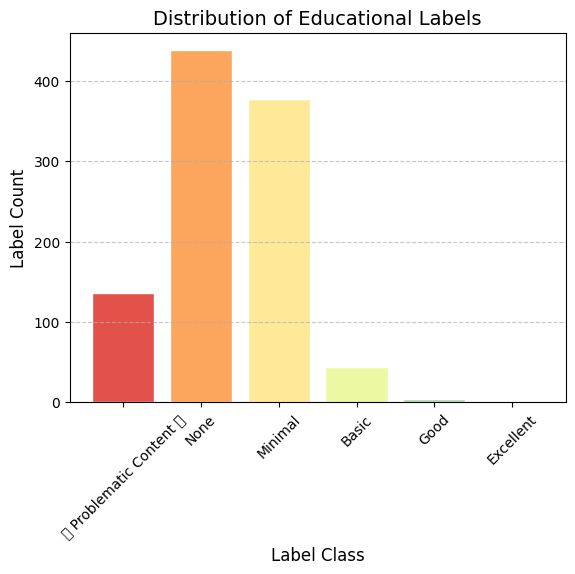

In [ ]:
plot_value_distribution(df2, "educational_value")

In [ ]:
df3 = pd.read_csv("test.csv")
df3

,text,educational_value_labels,problematic_content_label_present,problematic_content_label_agreement,soft_label_distribution,float_score,integer_score,educational_value
0,Spædbarnet og halstead essex lokal papir barn ...,['Minimal' 'None'],False,1.0,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",1.500000,2,['Minimal']
1,Bordel i Roskilde københavn sauna club review ...,['❗ Problematic Content ❗' '❗ Problematic Cont...,True,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,['❗ Problematic Content ❗']
2,Spatburgunder\nSpätburgunder er den tyske udga...,['Minimal' 'None'],False,1.0,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",1.500000,2,['Minimal']
3,Frodige kvinder swingerklub valbyXl åbyhøj rus...,['❗ Problematic Content ❗' '❗ Problematic Cont...,True,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,['❗ Problematic Content ❗']
4,"Mand til decorum kan vi daterer, men kun psyko...",['❗ Problematic Content ❗' '❗ Problematic Cont...,True,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,['❗ Problematic Content ❗']
...,...,...,...,...,...,...,...,...
995,Et flyttefirma kan godt være en god løsning hv...,['Minimal' 'None'],False,1.0,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0]",1.500000,2,['Minimal']
996,Oplev London i 3D og 4DUdgivet: 30/9 2009 - Re...,['None' 'None'],False,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.000000,1,['None']
997,I Hedensted Kommune betaler vi for at bruge la...,['Basic' 'Basic' 'Basic'],False,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",3.000000,3,['Basic']
998,Dato: 23/06/2022\nKlokkeslæt: 15:00 - 18:30\nS...,['None' 'Minimal' 'None'],False,1.0,"[0.0, 0.6666666666666666, 0.3333333333333333, ...",1.333333,1,['None']
